In [1]:
import numpy as np
from pipe import traverse
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from collections import defaultdict

#This class represents a undirected graph using adjacency processed_nodes representation
class Undirectedgraph:

	def __init__(self,m):
		self.graph = defaultdict(list) # default dictionary to store graph
		self.m = m
		self.m_flat = self.m.flatten()
		self.m_flat.sort()

	# function to add an edge to graph
	def addEdge(self,u,v):
		self.graph[u].append(v)

	# A utility function to find the subset of an element i
	def find_parent(self, parent,i):
		if parent[i] == -1:
			return i
		if parent[i]!= -1:
			return self.find_parent(parent,parent[i])

	# A utility function to do union of two subsets
	def union(self,parent,x,y):
		parent[x] = y


	def get_index(self, item):
		[x, y] = np.where(self.m == item)
		x, y = x[0], y[0]
		return x, y
	
	def is_neighbour(self,children,node):
		[r, c] = self.m.shape
		[x, y] = self.get_index(node)

		for child in children:
			if child in self.m[max(0,x-1):min(x+2,r), max(y-1,0):min(y+2, c)]:
				return True
		
		return False
    

	def check_for_parents(self,node,processed_nodes,parent):
		flag_no_neigbhour = True
		if len(processed_nodes)!=0:
			for idx,subset in enumerate(processed_nodes):
				# print(f'\nsubset {subset} from processed nodes {processed_nodes}, node is {node}')
				# print(f'is node {node} a neighbour of subset{subset}{self.is_neighbour(subset,node)}')
				if self.is_neighbour(subset,node):
					self.union(parent,subset[-1],node)
					# print(f'appending node {node} to processed_nodes {processed_nodes}')
					processed_nodes[idx].append(node)
					flag_no_neigbhour = False

			if flag_no_neigbhour:
				processed_nodes.append([node])
			else:
				# merge those sets where node is present
				for i in range(len(processed_nodes)-1):
					# print(i,processed_nodes)
					if i<len(processed_nodes)-1 and node in processed_nodes[i] and node in processed_nodes[i+1]:
						processed_nodes[i].extend(processed_nodes[i+1])
						processed_nodes.remove(processed_nodes[i+1])
						processed_nodes[i].remove(node)
		else:
			processed_nodes.append([node])
		return processed_nodes,parent

In [3]:
def reeb_mod(m):
    g = Undirectedgraph(m)
    G = nx.Graph()
    processed_nodes = []
    parent = [-1]*(len(g.m_flat)+1)                                             # O(n)  space complexity

    for node in g.m_flat:
        processed_nodes,parent = g.check_for_parents(node,processed_nodes,parent)
    
    parent = parent[:-1]
    print(f'parent index is {parent}')
    for idx,node in enumerate(parent):
        if idx>0:
            G.add_edge(idx,node)
        
    plt.plot()
    nx.draw_networkx(G, font_weight='bold',cmap='cyan')



[[14 10  4 15 22]
 [25 17  1 18  9]
 [24 20 19  5 13]
 [ 7  2  6 12 21]
 [23 16 11  3  8]]
parent index is [-1, 4, 6, 6, 5, 6, 8, 9, 11, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


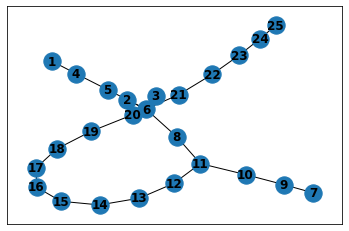

In [21]:
input_matrix = np.array([
    [1, 6, 3],
    [2, 7, 4],
    [5, 8, 9]
])
input_matrix = np.array([
    [1,7,12,13],
    [9,2,6,5 ],
    [14,8,11,10],
    [15,16,4,3]
])
input_matrix = np.array([
                        [ 8,  1,  4,  5],
                        [ 9,  7, 12, 16],
                        [14, 11,  6,  2],
                        [15,  3, 13, 10]])
input_matrix = np.random.choice(np.arange(1,26),size=(5,5),replace=False)
print(input_matrix)
reeb_mod(input_matrix)
